# **Hands-On Machine Learning Project**
## **Topic 20: Credit Data**
### Florian Korn, Vincent Bläske, Dennis Götz

***
# **Table of Content**
**[V. Shortlist Models](#shortlist)**<br>
**[VI. Fine Tuneing](#finetuneingmodels)**<br>
***

## **V. Shortlist Models**  <a id='shortlist'></a>
**[1. Feature Selection and Encoding Pipes](#fsep)**<br>
**[2. Train models with standard parameters and shortlist](#quickdirty)**<br>

### **Import of librariers:**

In [1]:
import pandas as pd
from pandas import get_dummies
import numpy as np
from sklearn.model_selection import train_test_split, KFold, cross_validate, GridSearchCV, RandomizedSearchCV, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn import tree, linear_model, svm
from pprint import pprint
import matplotlib.pyplot as plt
import seaborn as sns

### **Load stored data:**

In [2]:
%store -r attributes
%store -r num_attribs
%store -r cat_attribs
%store -r binary_attribs
%store -r dict_ordinal_map
%store -r data_values
%store -r train_set
%store -r test_set
%store -r X_train
%store -r y_train
%store -r X_test
%store -r y_test

### **1. Feature Selection and Encoding Pipes** <a id='fsep'></a> <br> 
Here a pipe encoder and selector preprocesses the data.

In [3]:
def pipe_encoder_selector(dict_ordinal_map: dict, columns_excluded: list, cat_attribs: list, binary_attribs: list, num_attribs: list,  target: str, ordinal_encoding = True):
    '''
    This function allows to build a preprocess pipeline with a specific target variable and numerical as also categorical features (with a specific ordering)

    Parameters:
    dict_ordinal_map : a dictionary with the ordered values of categories (specific order)
    columns_excluded : feature selection for the columns we don't want
    cat_attribs : all categorical attributes in our df
    binary_attribs : all binary attributes in our df
    num_attribs : all numerical attribs in our df
    target : target variable (only one possible)
    ordinal_encoding : if all categorical features should be encoded ordinal or one-hot-encoding

    Returns:
    Preprocess pipelines
    '''
    num_pipeline = make_pipeline(
        StandardScaler())
    
    column_target = [target]
    column_cat = [i for i in cat_attribs if (i not in columns_excluded) and (i != target) and (i not in binary_attribs)]
    column_bin = [i for i in cat_attribs if (i not in columns_excluded) and (i not in column_cat) and (i != target)]

    if ordinal_encoding:
        cat_pipeline = make_pipeline( 
            OrdinalEncoder(dtype = 'int', categories = [dict_ordinal_map[i] for i in column_cat]))
    else:
        cat_pipeline = make_pipeline(
            OneHotEncoder(dtype = 'int', sparse_output=False, handle_unknown ='ignore'))
    
    bin_pipeline = make_pipeline(
            OrdinalEncoder(dtype = 'int', categories = [dict_ordinal_map[i] for i in column_bin]))

    target_pipeline = make_pipeline(
            OrdinalEncoder(dtype = 'int', categories = [dict_ordinal_map[i] for i in column_target]))

    preprocessing = make_column_transformer( 
        (num_pipeline, num_attribs), 
        (cat_pipeline, column_cat),
        (bin_pipeline, column_bin),
        #(target_pipeline, column_target),
        remainder = 'drop', verbose_feature_names_out = False).set_output(transform="pandas")
    
    preprocessing_target = make_column_transformer( 
        (target_pipeline, column_target),
        remainder = 'drop', verbose_feature_names_out = False)

    return preprocessing, preprocessing_target

columns_excluded = ['foreign worker', 'Personal status and sex']

**[Back to V. Shortlist Models](#shortlist)**<br>

### **2. Train models with standard parameters and short list** <a id='quickdirty'></a> <br>
Create the Pipelines with the quick and dirty models.

In [4]:
# Create Preprocess Pipeline
preprocess_ordinal, preprocess_ordinal_target = pipe_encoder_selector(dict_ordinal_map, columns_excluded, cat_attribs, binary_attribs, num_attribs, 'Credit rating', True)
preprocess_onehot, preprocess_onehot_target = pipe_encoder_selector(dict_ordinal_map, columns_excluded, cat_attribs, binary_attribs, num_attribs, 'Credit rating', False)

# Create Model Pipeline

# Linear Models
## Linear Regression
pipe_reg = make_pipeline(
    preprocess_ordinal,
    LinearRegression())

pipe_reg_one = make_pipeline(
    preprocess_onehot,
    LinearRegression())

## Ridge Regression
pipe_ridgereg = make_pipeline(
    preprocess_ordinal,
    linear_model.Ridge())

pipe_ridgereg_one = make_pipeline(
    preprocess_onehot,
    linear_model.Ridge())

## Lasso Regression
pipe_lassoreg = make_pipeline(
    preprocess_ordinal,
    linear_model.Lasso())

pipe_lassoreg_one = make_pipeline(
    preprocess_onehot,
    linear_model.Lasso())

## Logistic Regression
pipe_logreg = make_pipeline(
    preprocess_ordinal,
    LogisticRegression())

pipe_logreg_one = make_pipeline(
    preprocess_onehot,
    LogisticRegression())

# kNN
pipe_knn = make_pipeline(
    preprocess_ordinal,
    KNeighborsClassifier())

pipe_knn_one = make_pipeline(
    preprocess_onehot,
    KNeighborsClassifier())

# naiveBayes
pipe_gaussiannb = make_pipeline(
    preprocess_ordinal,
    GaussianNB())

pipe_gaussiannb_one = make_pipeline(
    preprocess_onehot,
    GaussianNB())

# Support Vector Machine
pipe_svm = make_pipeline(
    preprocess_ordinal,
    svm.SVC())

pipe_svm_one = make_pipeline(
    preprocess_onehot,
    svm.SVC())

# Random Forest
pipe_rf = make_pipeline(
    preprocess_ordinal,
    RandomForestClassifier())

pipe_rf_one = make_pipeline(
    preprocess_onehot,
    RandomForestClassifier())

# Extra Trees
pipe_extratrees = make_pipeline(
    preprocess_ordinal,
    ExtraTreesClassifier())

pipe_extratrees_one = make_pipeline(
    preprocess_onehot,
    ExtraTreesClassifier())

# Gradient Boosting Classifier
pipe_gradientboost = make_pipeline(
    preprocess_ordinal,
    GradientBoostingClassifier())

pipe_gradientboost_one = make_pipeline(
    preprocess_onehot,
    GradientBoostingClassifier())

# AdaBoost Classifier
pipe_adaboost = make_pipeline(
    preprocess_ordinal,
    AdaBoostClassifier())

pipe_adaboost_one = make_pipeline(
    preprocess_onehot,
    AdaBoostClassifier())

# SGD Classifier
pipe_sgd = make_pipeline(
    preprocess_ordinal,
    SGDClassifier())

pipe_sgd_one = make_pipeline(
    preprocess_onehot,
    SGDClassifier())

# Decision Tree
pipe_decisiontree = make_pipeline(
    preprocess_ordinal,
    tree.DecisionTreeClassifier())

pipe_decisiontree_one = make_pipeline(
    preprocess_onehot,
    tree.DecisionTreeClassifier())

# Neural Network Classifier
pipe_neuralnetwork = make_pipeline(
    preprocess_ordinal,
    MLPClassifier())

pipe_neuralnetwork_one = make_pipeline(
    preprocess_onehot,
    MLPClassifier())

display(preprocess_ordinal)
display(preprocess_ordinal_target)
display(preprocess_onehot)
display(preprocess_onehot_target)

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('standardscaler',
                                                  StandardScaler())]),
                                 ['Installment rate in percentage of '
                                  'disposable income',
                                  'Duration in month', 'Credit amount',
                                  'Number of existing credits at this bank',
                                  'Age in years', 'Present residence since',
                                  'Number of people being liable to provide '
                                  'maintenance for']),
                                ('pipeline-2',
                                 Pipeline(steps=[('ordina...
                                  'Credit history', 'Purpose',
                                  'Savings account/bonds',
                                  'Present employment since',
                                  'Other debtors / guarantors', 'Property',
                                  'Other installment plans', 'Housing',
                                  'Job']),
                                ('pipeline-3',
                                 Pipeline(steps=[('ordinalencoder',
                                                  OrdinalEncoder(categories=[['yes, '
                                                                              'registered '
                                                                              'under '
                                                                              'the '
                                                                              'customers '
                                                                              'name',
                                                                              'none']],
                                                                 dtype='int'))]),
                                 ['Telephone'])],
                  verbose_feature_names_out=False)

ColumnTransformer(transformers=[('pipeline',
                                 Pipeline(steps=[('ordinalencoder',
                                                  OrdinalEncoder(categories=[['good',
                                                                              'bad']],
                                                                 dtype='int'))]),
                                 ['Credit rating'])],
                  verbose_feature_names_out=False)

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('standardscaler',
                                                  StandardScaler())]),
                                 ['Installment rate in percentage of '
                                  'disposable income',
                                  'Duration in month', 'Credit amount',
                                  'Number of existing credits at this bank',
                                  'Age in years', 'Present residence since',
                                  'Number of people being liable to provide '
                                  'maintenance for']),
                                ('pipeline-2',
                                 Pipeline(steps=[('onehot...
                                  'Credit history', 'Purpose',
                                  'Savings account/bonds',
                                  'Present employment since',
                                  'Other debtors / guarantors', 'Property',
                                  'Other installment plans', 'Housing',
                                  'Job']),
                                ('pipeline-3',
                                 Pipeline(steps=[('ordinalencoder',
                                                  OrdinalEncoder(categories=[['yes, '
                                                                              'registered '
                                                                              'under '
                                                                              'the '
                                                                              'customers '
                                                                              'name',
                                                                              'none']],
                                                                 dtype='int'))]),
                                 ['Telephone'])],
                  verbose_feature_names_out=False)

ColumnTransformer(transformers=[('pipeline',
                                 Pipeline(steps=[('ordinalencoder',
                                                  OrdinalEncoder(categories=[['good',
                                                                              'bad']],
                                                                 dtype='int'))]),
                                 ['Credit rating'])],
                  verbose_feature_names_out=False)

Compute the scores of the pipelines with the quick and dirty models.

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  ['Installment rate in '
                                                   'percentage of disposable '
                                                   'income',
                                                   'Duration in month',
                                                   'Credit amount',
                                                   'Number of existing credits '
                                                   'at this bank',
                                                   'Age in years',
                                                   'Present residence since',
                                                   'Number of people being '
                                                   'liable to provide '
                                                   'maintenance fo...
                                                   'Savings account/bonds',
                                                   'Present employment since',
                                                   'Other debtors / guarantors',
                                                   'Property',
                                                   'Other installment plans',
                                                   'Housing', 'Job']),
                                                 ('pipeline-3',
                                                  Pipeline(steps=[('ordinalencoder',
                                                                   OrdinalEncoder(categories=[['yes, '
                                                                                               'registered '
                                                                                               'under '
                                                                                               'the '
                                                                                               'customers '
                                                                                               'name',
                                                                                               'none']],
                                                                                  dtype='int'))]),
                                                  ['Telephone'])],
                                   verbose_feature_names_out=False)),
                ('linearregression', LinearRegression())])

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  ['Installment rate in '
                                                   'percentage of disposable '
                                                   'income',
                                                   'Duration in month',
                                                   'Credit amount',
                                                   'Number of existing credits '
                                                   'at this bank',
                                                   'Age in years',
                                                   'Present residence since',
                                                   'Number of people being '
                                                   'liable to provide '
                                                   'maintenance fo...
                                                   'Savings account/bonds',
                                                   'Present employment since',
                                                   'Other debtors / guarantors',
                                                   'Property',
                                                   'Other installment plans',
                                                   'Housing', 'Job']),
                                                 ('pipeline-3',
                                                  Pipeline(steps=[('ordinalencoder',
                                                                   OrdinalEncoder(categories=[['yes, '
                                                                                               'registered '
                                                                                               'under '
                                                                                               'the '
                                                                                               'customers '
                                                                                               'name',
                                                                                               'none']],
                                                                                  dtype='int'))]),
                                                  ['Telephone'])],
                                   verbose_feature_names_out=False)),
                ('linearregression', LinearRegression())])

For ordinal encoded data:


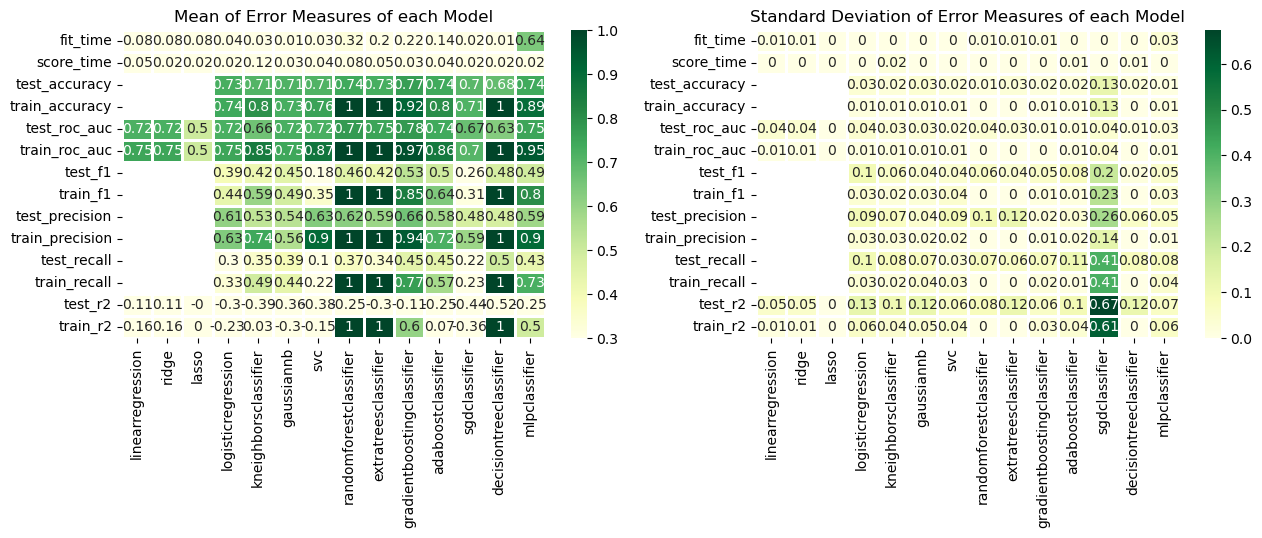

For one-hot encoded data:


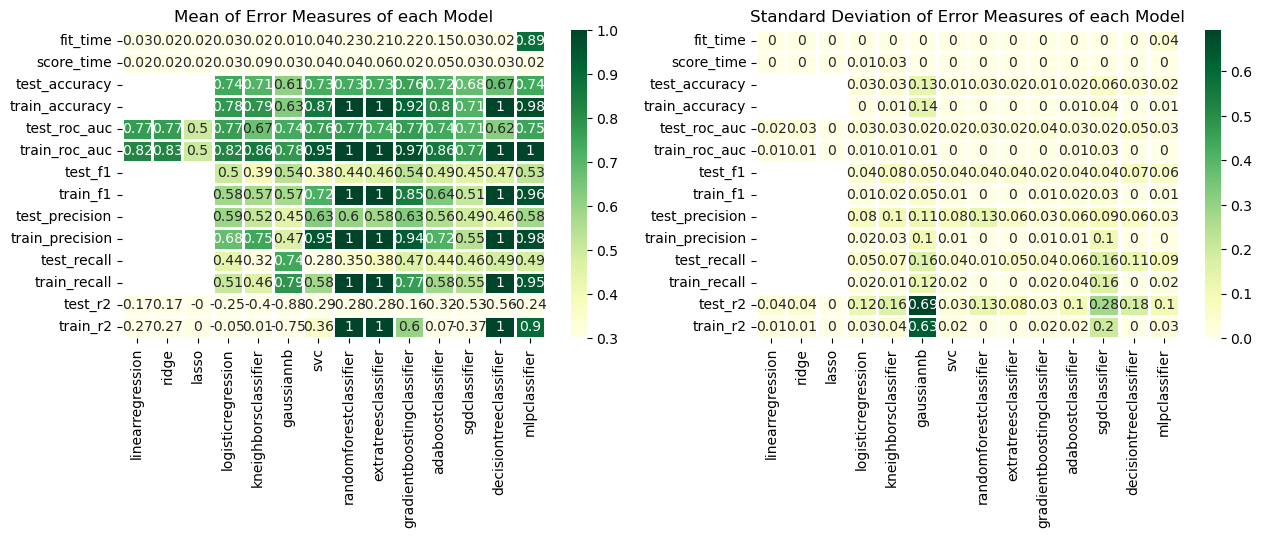

,linearregression,ridge,lasso,logisticregression,kneighborsclassifier,gaussiannb,svc,randomforestclassifier,extratreesclassifier,gradientboostingclassifier,adaboostclassifier,sgdclassifier,decisiontreeclassifier,mlpclassifier
fit_time,0.029297,0.021902,0.021261,0.030149,0.015860,0.014518,0.036841,0.227343,0.213815,0.217641,0.146642,0.027195,0.018624,0.890750
score_time,0.018862,0.017601,0.015374,0.028683,0.090214,0.025604,0.043204,0.043636,0.061208,0.024431,0.047363,0.030953,0.028846,0.022745
test_accuracy,NaN,NaN,NaN,0.738750,0.707500,0.608750,0.730000,0.732500,0.732500,0.757500,0.723750,0.681250,0.672500,0.740000
train_accuracy,NaN,NaN,NaN,0.780312,0.791563,0.631250,0.865625,0.999687,1.000000,0.915938,0.805000,0.713125,1.000000,0.979375
test_roc_auc,0.770403,0.771811,0.500000,0.766808,0.670964,0.735289,0.763102,0.772509,0.741589,0.771156,0.737754,0.709482,0.621108,0.753308
train_roc_auc,0.824491,0.825089,0.500000,0.823566,0.858288,0.781099,0.950739,1.000000,1.000000,0.970956,0.860583,0.765341,1.000000,0.998347
test_f1,NaN,NaN,NaN,0.501134,0.391418,0.539297,0.378013,0.439265,0.458333,0.535160,0.485601,0.451478,0.469157,0.526532
train_f1,NaN,NaN,NaN,0.581115,0.569923,0.571714,0.721998,0.999469,1.000000,0.845601,0.640893,0.513524,1.000000,0.964892
test_precision,NaN,NaN,NaN,0.591748,0.518410,0.448246,0.625767,0.599372,0.584016,0.630940,0.555584,0.493427,0.456356,0.579194
train_precision,NaN,NaN,NaN,0.678854,0.748139,0.466008,0.950919,1.000000,1.000000,0.941481,0.715684,0.545094,1.000000,0.982782


In [5]:
def scores_std(X_train, y_train, kfold, pipeline_list, preprocess_pipe_target):
    '''
    This function calculates the standard deviation of specific error measures of ML models.

    Parameters:
    X_train : the training data with all features
    y_train : the training data with the target variable
    kfold : the cross validation strategy
    pipeline_list : all pipelines
    preprocess_pipe_target : is the preprocessing pipe for the target variable

    Returns:
    Computed standard devition of error measures as DataFrame
    '''
    scores_std = pd.concat([pd.DataFrame(pd.DataFrame(cross_validate(pipeline_list[i], 
                                                            X_train,
                                                            preprocess_pipe_target.fit_transform(y_train),
                                                            scoring=['accuracy', 'roc_auc', 'f1', 'precision', 'recall', 'r2'],
                                                            cv=kfold,
                                                            n_jobs=-1,
                                                            return_train_score=True)).std(), columns = [i]) for i in range(len(pipeline_list))], axis = 1)
    return scores_std

def scores_mean(X_train, y_train, kfold, pipeline_list, preprocess_pipe_target):
    '''
    This function calculates the mean of specific error measures of ML models.

    Parameters:
    X_train : the training data with all features
    y_train : the training data with the target variable
    kfold : the cross validation strategy
    pipeline_list : all pipelines
    preprocess_pipe_target : is the preprocessing pipe for the target variable

    Returns:
    Computed mean of error measures as DataFrame
    '''
    scores_mean = pd.concat([pd.DataFrame(pd.DataFrame(cross_validate(pipeline_list[i], 
                                                            X_train,
                                                            preprocess_pipe_target.fit_transform(y_train),
                                                            scoring=['accuracy', 'roc_auc', 'f1', 'precision', 'recall', 'r2'],
                                                            cv=kfold,
                                                            n_jobs=-1,
                                                            return_train_score=True)).mean(), columns = [i]) for i in range(len(pipeline_list))], axis = 1)
    return scores_mean
    
def score_quick_models(X_train: pd.DataFrame, y_train, kfold, pipeline_list, preprocess_pipe_target, sub_string = []):
    '''
    This function computes the error measures of quick and dirty models.

    Parameters:
    X_train : the training data with all features
    y_train : the training data with the target variable
    kfold : the cross validation strategy
    pipeline_list : all pipelines
    preprocess_pipe_target : is the preprocessing pipe for the target variable
    sub_string : string to put after model names

    Returns:
    Two heatmaps with the mean and standard deviation of the error measures
    '''
    scores_means = scores_mean(X_train, y_train, kfold, pipeline_list, preprocess_pipe_target)
    scores_stds = scores_std(X_train, y_train, kfold, pipeline_list, preprocess_pipe_target)

    if sub_string == []:
        sub_string = ["" for i in range(len(pipeline_list))]
    columns = [pipeline_list[i].steps[-1][0] + sub_string[i] for i in range(len(pipeline_list))]
    scores_means.columns = columns
    scores_stds.columns = columns

    # Visualize scores
    fig, (ax1, ax2) = plt.subplots(1,2, figsize = (15,4))
    g1 = sns.heatmap(scores_means, vmin = 0.3, vmax = 1, center = 0.65, linewidth = 1, linecolor = 'white', cmap = 'YlGn', annot = np.round(scores_means, 2), ax = ax1)
    ax1.title.set_text('Mean of Error Measures of each Model')
    g2 = sns.heatmap(scores_stds, linewidth = 1, linecolor = 'white', cmap = 'YlGn', annot = np.round(scores_stds, 2), ax = ax2)
    ax2.title.set_text('Standard Deviation of Error Measures of each Model')
    plt.show()
    return scores_means

# K Fold iterator
kfold = KFold(n_splits=5, shuffle=True, random_state=0)

# List of pipelines
pipeline_list_ord = [pipe_reg,
                 pipe_ridgereg,
                 pipe_lassoreg,
                 pipe_logreg,
                 pipe_knn,
                 pipe_gaussiannb,
                 pipe_svm,
                 pipe_rf,
                 pipe_extratrees,
                 pipe_gradientboost,
                 pipe_adaboost,
                 pipe_sgd,
                 pipe_decisiontree,
                 pipe_neuralnetwork]

pipeline_list_one = [pipe_reg_one,
                 pipe_ridgereg_one,
                 pipe_lassoreg_one,
                 pipe_logreg_one,
                 pipe_knn_one,
                 pipe_gaussiannb_one,
                 pipe_svm_one,
                 pipe_rf_one,
                 pipe_extratrees_one,
                 pipe_gradientboost_one,
                 pipe_adaboost_one,
                 pipe_sgd_one,
                 pipe_decisiontree_one,
                 pipe_neuralnetwork_one]

# compute scores of quick and dirty models

display(pipeline_list_ord[0])
display(pipeline_list_one[0])

print('For ordinal encoded data:')
score_quick_models(train_set.iloc[:, :-1], train_set.iloc[:, [-1]], kfold, pipeline_list_ord, preprocess_ordinal_target)
print('For one-hot encoded data:')
score_quick_models(train_set.iloc[:, :-1], train_set.iloc[:, [-1]], kfold, pipeline_list_one, preprocess_onehot_target)

When we look at the scores to identify the most promising models, one should weight the importance of the scores on the test set higher than on the train set.<br> 
The R2 is a great error measure for continous predictions, as in regression tasks, therefore it shouldn't be of interest in models which have a categorical outcome.<br>
It is <u>worse to classify a customer as good (0) when they are bad (1)</u> than it is to classify a customer as bad when they are good (1). The metrics that describe this well are recall (the proportion of true positives among all positives) and roc auc, which describes the area under the curve; if it is 1, we separate the classes perfectly and therefore identify true positives with a very high probability.<br>

#### **Overall**
Between the error measures of the one-hot encoded data and the ordinal encoded data, we see that the mlpclassifier, SVM and sgdclassifier performs better in terms of mean error when one-hot encoded.
* <u>Mean of the error measures</u>
    * **Ordinal encoded (three best models)**
        * Roc_auc on the test data: 
            * Ensemble: Random Forest, Extra Trees, Gradient Boosting
            * SVM (SVC)
            * mlpclassifier (Neural Network)
        * Recall on the test data: 
            * Decision Tree
            * Ensemble: Random Forest, AdaBoost, Gradient Boosting
            * Naive Bayes
    * **One-hot-encoded (three best models)**
        * Roc_auc on the test data: 
            * SVM (SVC)
            * Ensemble: Random Forest, Gradient Boosting
            * Logistic Regression
        * Recall on the test data:
            * Naive Bayes
            * mlpclassifier (Neural Network)
            * Logistic Regression

* <u>Standard deviation of the error measures</u>
    * **Ordinal encoded**
        * Slightly higher compared to other models:
            * R2
                * Decision Tree
                * kNN
                * Logistic Regression
                * naive Bayes
                * mlpclassifier (Neural Network)
                * AdaBoost
            * Recall
                * Logistic Regression
            * Precision
                * kNN, naive Bayes
    * **One-hot-encoded**
        * Highest compared to other models:
            * R2
                * SVM (SVC)

### **Decision**
The most promising models to fine tune are:
* **Ordinal encoded**
    * Ensemble: Random Forest, Extra Trees, Gradient Boosting
    * SVM (SVC)
    * mlpclassifier (Neural Network)
    * Decision Tree
    * Naive Bayes
* **One-hot-encoded**
    * SVM
    * Ensemble: Random Forest, Gradient Boosting
    * Logistic Regression
    * Naive Bayes
    * mlpclassifier (Neural Network)
<br>

For the fine tuneing we suggest to look at the **Linear Regression** as a negative example.<br>
Amongst the **ensemble methods**, we decided for the **Random Forest**, as it performs well on every evaluation metric tested, resulting in a higher mean in the performance metrics compared to the other ensemble methods tested. Most importantly, it has a good balance between precission and recall, which indicates that the model is capable of minimizing misclassification.<br>

A positive outcome we think might bring SVM, Logistic Regression, Random Forest, Decision Tree

**[Back to V. Shortlist Models](#shortlist)**<br>

***
## **6. Fine Tuneing** <a id='finetuneingmodels'></a> <br>
**[1. Linear Regression](#lrfine)**<br>
**[2. Logistic Regression](#lorefine)**<br>
**[3. Random Forest](#rffine)**<br>
***


### **1. Linear Regression** <a id='lrfine'></a> <br>
Forward / backward selection strategy

In [6]:
sfs_linear_forward = SequentialFeatureSelector(estimator = LinearRegression(),
                                              n_features_to_select = 'auto',
                                              tol = 0.01,
                                              direction = 'forward',
                                              scoring = 'r2',
                                              cv = kfold)

sfs_linear_backward = SequentialFeatureSelector(estimator = LinearRegression(),
                                              n_features_to_select = 'auto',
                                              tol = 0.01,
                                              direction = 'backward',
                                              scoring = 'r2',
                                              cv = kfold)

Pipes for ordinal (backward and forward selection) and one-hot (backward and forward selection)

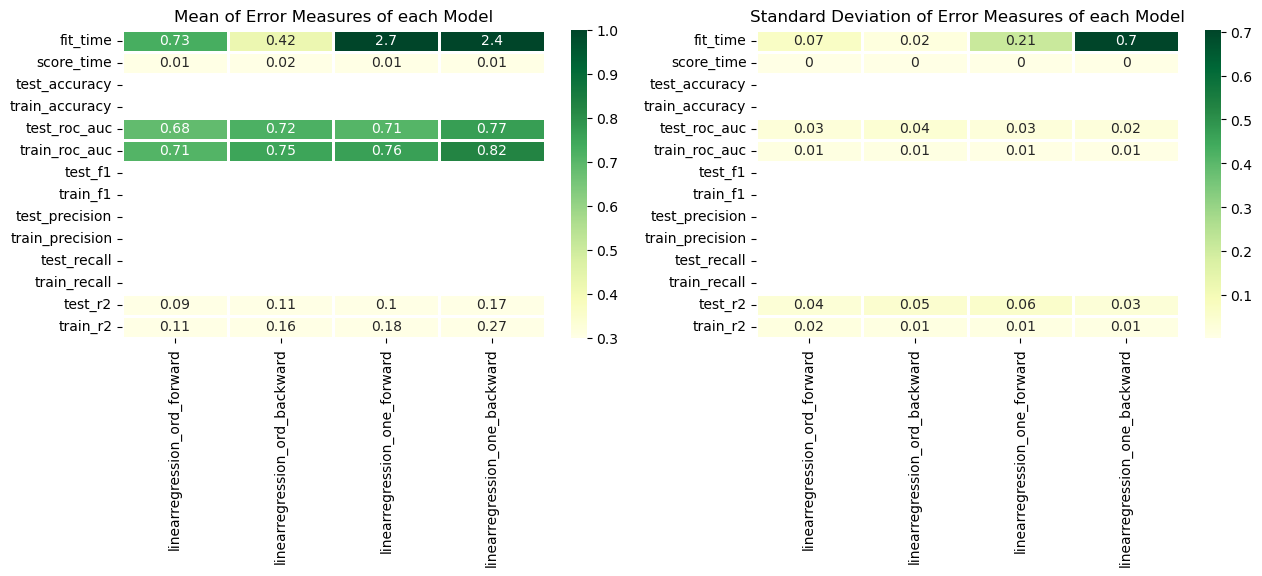

In [7]:
pipe_reg_ord_forward = make_pipeline(
    preprocess_ordinal,
    sfs_linear_forward,
    LinearRegression()
    )

pipe_reg_ord_backward = make_pipeline(
    preprocess_ordinal,
    sfs_linear_backward,
    LinearRegression()
    )

pipe_reg_one_forward = make_pipeline(
    preprocess_onehot,
    sfs_linear_forward,
    LinearRegression()
    )

pipe_reg_one_backward = make_pipeline(
    preprocess_onehot,
    sfs_linear_backward,
    LinearRegression()
    )

pipeline_list_for_back = [pipe_reg_ord_forward, pipe_reg_ord_backward, pipe_reg_one_forward, pipe_reg_one_backward]

scores_mean_fine1 = score_quick_models(
            train_set.iloc[:, :-1], 
            train_set.iloc[:, [-1]],  
            kfold,
            pipeline_list_for_back,
            preprocess_ordinal_target,
            ['_ord_forward', '_ord_backward', '_one_forward', '_one_backward'])

Feature interpretation:<br>
Here you see the coefficients of the linear regression models if forward or backward and ordinal encoded or one-hot encoded is chosen.

In [8]:
def coef_intercept(train_set, pipe_reg, preprocess, preprocess_target):
    model1 = pipe_reg.fit(train_set.iloc[:, :-1], preprocess_target.fit_transform(train_set.iloc[:, [-1]]))
    coef1 = model1.steps[-1][1].coef_
    intercept1 = model1.steps[-1][1].intercept_
    column_names = preprocess.fit_transform(train_set.iloc[:, :-1]).columns[model1.steps[-2][1].get_support()]
    score1 = model1.score(train_set.iloc[:, :-1], preprocess_target.fit_transform(train_set.iloc[:, [-1]]))

    df_coef_int = pd.DataFrame(coef1, columns = column_names, index = ['Coefficients'])
    df_coef_int['Intercept'] = intercept1
    df_coef_int['Score'] = score1

    return df_coef_int


m1_reg = coef_intercept(train_set, pipe_reg_ord_forward, preprocess_ordinal, preprocess_ordinal_target)
m2_reg = coef_intercept(train_set, pipe_reg_ord_backward, preprocess_ordinal, preprocess_ordinal_target)
m3_reg = coef_intercept(train_set, pipe_reg_one_forward, preprocess_onehot, preprocess_onehot_target)
m4_reg = coef_intercept(train_set, pipe_reg_one_backward, preprocess_onehot, preprocess_onehot_target)

df_dict = {
    'm1': m1_reg,
    'm2': m2_reg,
    'm3': m3_reg,
    'm4': m4_reg,
}

df_models_coef = pd.concat(df_dict.values(), ignore_index=True)
df_models_coef.index = ['reg_ord_forward', 'reg_ord_backward', 'reg_one_forward', 'reg_one_backward']
df_models_coef


,Duration in month,Status of existing checking account,Credit history,Intercept,Score,Installment rate in percentage of disposable income,Credit amount,Number of existing credits at this bank,Age in years,Present residence since,...,Other installment plans_bank,Other installment plans_none,Other installment plans_stores,Housing_for free,Housing_own,Housing_rent,Job_management/ self-employed/ highly qualified employee/ officer,Job_skilled employee / official,Job_unemployed/ unskilled - non-resident,Job_unskilled - resident
reg_ord_forward,0.085620,0.068022,-0.083658,4.434694e-01,0.111343,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
reg_ord_backward,0.060880,0.069980,-0.087908,6.178091e-01,0.154136,0.039093,0.030330,0.043268,-0.020965,0.002085,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
reg_one_forward,0.082882,NaN,NaN,3.665741e-01,0.157277,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
reg_one_backward,0.112533,NaN,NaN,-2.799783e+13,-0.285978,0.029757,0.023421,-0.033753,0.034343,-0.009794,...,4.293338e+12,4.293338e+12,4.293338e+12,1.288306e+12,1.288306e+12,1.288306e+12,5.219860e+12,5.219860e+12,5.219860e+12,5.219860e+12


The fine tuneing didn't improve the model. The performance of R2 is seriously low and therefore the model is not suitable to put into production or gain valuable insights from the feature selection.

**[Back to VI. Fine Tuneing](#finetuneingmodels)**<br>

### **2. Logistic Regression** <a id='lorefine'></a> <br>
Forward / backward selection strategy based on R2.

In [9]:
sfs_log_forward = SequentialFeatureSelector(estimator = LogisticRegression(),
                                              n_features_to_select = 'auto',
                                              tol = 0.01,
                                              direction = 'forward',
                                              scoring = 'r2',
                                              cv = kfold)

sfs_log_backward = SequentialFeatureSelector(estimator = LogisticRegression(),
                                              n_features_to_select = 'auto',
                                              tol = 0.01,
                                              direction = 'backward',
                                              scoring = 'r2',
                                              cv = kfold)

Pipes for ordinal (backward and forward selection) and one-hot (backward and forward selection)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  ['Installment rate in '
                                                   'percentage of disposable '
                                                   'income',
                                                   'Duration in month',
                                                   'Credit amount',
                                                   'Number of existing credits '
                                                   'at this bank',
                                                   'Age in years',
                                                   'Present residence since',
                                                   'Number of people being '
                                                   'liable to provide '
                                                   'maintenance fo...
                                                                   OrdinalEncoder(categories=[['yes, '
                                                                                               'registered '
                                                                                               'under '
                                                                                               'the '
                                                                                               'customers '
                                                                                               'name',
                                                                                               'none']],
                                                                                  dtype='int'))]),
                                                  ['Telephone'])],
                                   verbose_feature_names_out=False)),
                ('sequentialfeatureselector',
                 SequentialFeatureSelector(cv=KFold(n_splits=5, random_state=0, shuffle=True),
                                           estimator=LogisticRegression(),
                                           n_features_to_select='auto',
                                           scoring='r2', tol=0.01)),
                ('logisticregression', LogisticRegression())])

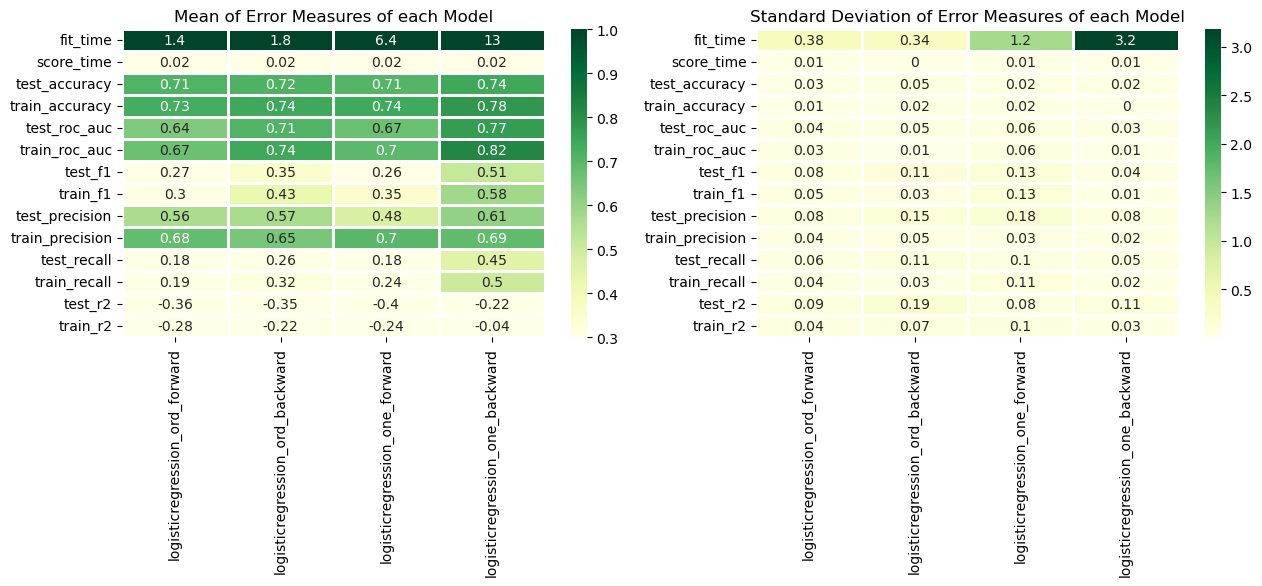

In [24]:
pipe_log_ord_forward = make_pipeline(
    preprocess_ordinal,
    sfs_log_forward,
    LogisticRegression()
    )

pipe_log_ord_backward = make_pipeline(
    preprocess_ordinal,
    sfs_log_backward,
    LogisticRegression()
    )

pipe_log_one_forward = make_pipeline(
    preprocess_onehot,
    sfs_log_forward,
    LogisticRegression()
    )

pipe_log_one_backward = make_pipeline(
    preprocess_onehot,
    sfs_log_backward,
    LogisticRegression()
    )

pipeline_list_for_log = [pipe_log_ord_forward, pipe_log_ord_backward, pipe_log_one_forward, pipe_log_one_backward]

display(pipe_log_ord_forward)

scores_mean_fine2 = score_quick_models(
    train_set.iloc[:, :-1], 
    train_set.iloc[:, [-1]],  
    kfold,
    pipeline_list_for_log,
    preprocess_ordinal_target,
    ['_ord_forward', '_ord_backward', '_one_forward', '_one_backward'])

In the mean of error measure for each model plot, we see that backward feature selection on the one-hot-encoded data has the highest roc_auc, therefore can separate best between true positive rate and false positive rate. In regards to the recall it performs much better than the other models. Therefore we would suggest if someone would like to employ logistic regression to chose it with backward feature selection and the categorical data should be one-hot-encoded. <br><br>

Intercept and coefficients of the fitted models:

In [11]:
def coef_intercept_log(train_set: pd.DataFrame(), pipe_reg, preprocess, preprocess_target):
    model1 = pipe_reg.fit(train_set.iloc[:, :-1], preprocess_target.fit_transform(train_set.iloc[:, [-1]]).ravel())
    coef1 = model1.steps[-1][1].coef_
    intercept1 = model1.steps[-1][1].intercept_
    column_names = preprocess.fit_transform(train_set.iloc[:, :-1]).columns[model1.steps[-2][1].get_support()]
    score1 = model1.score(train_set.iloc[:, :-1], preprocess_target.fit_transform(train_set.iloc[:, [-1]]))

    df_coef_int = pd.DataFrame(coef1, columns = column_names)
    df_coef_int['Intercept'] = intercept1
    df_coef_int['Score'] = score1

    return df_coef_int, model1


m1_log, model1 = coef_intercept_log(train_set, pipe_log_ord_forward, preprocess_ordinal, preprocess_ordinal_target)
m2_log, model2 = coef_intercept_log(train_set, pipe_log_ord_backward, preprocess_ordinal, preprocess_ordinal_target)
m3_log, model3 = coef_intercept_log(train_set, pipe_log_one_forward, preprocess_onehot, preprocess_onehot_target)
m4_log, model4 = coef_intercept_log(train_set, pipe_log_one_backward, preprocess_onehot, preprocess_onehot_target)

df_dict = {
    'm1': m1_log,
    'm2': m2_log,
    'm3': m3_log,
    'm4': m4_log,
}

df_models_coef = pd.concat(df_dict.values(), ignore_index=True)
df_models_coef.index = ['log_ord_forward', 'log_ord_backward', 'log_one_forward', 'log_one_backward']
df_models_coef

,Credit amount,Credit history,Intercept,Score,Installment rate in percentage of disposable income,Duration in month,Number of existing credits at this bank,Age in years,Present residence since,Status of existing checking account,...,Other installment plans_bank,Other installment plans_none,Other installment plans_stores,Housing_for free,Housing_own,Housing_rent,Job_management/ self-employed/ highly qualified employee/ officer,Job_skilled employee / official,Job_unemployed/ unskilled - non-resident,Job_unskilled - resident
log_ord_forward,0.303866,-0.480507,0.298812,0.72875,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
log_ord_backward,NaN,-0.476214,0.767377,0.73750,0.16961,0.409878,0.235787,-0.131654,0.010510,0.376896,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
log_one_forward,NaN,NaN,-0.354159,0.74000,NaN,NaN,0.168588,NaN,-0.032052,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
log_one_backward,0.120845,NaN,-1.811812,0.78250,NaN,0.384751,0.222498,-0.110002,-0.044111,NaN,...,0.047531,-0.295239,0.249067,-0.167962,-0.183907,0.353229,0.18058,0.150105,-0.390116,0.060789


Confusion Matrix of logistic regression ordinal and one-hot-encoded (differentiated by forward / backward feature selection)

In [12]:
def pred_confusion_matrix(test_set, pipeline_list, preprocess_target):

    y_pred = cross_val_predict(estimator = pipeline_list, 
        X = test_set.iloc[:, :-1], 
        y = np.array(preprocess_target.fit_transform(test_set.iloc[:, [-1]])).ravel(),  
        cv = kfold)
    
    conf_mat = confusion_matrix(preprocess_target.fit_transform(test_set.iloc[:, [-1]]).ravel(), y_pred)

    return conf_mat

plot_conf1 = pred_confusion_matrix(train_set, pipeline_list_for_log[0], preprocess_ordinal_target)
plot_conf2 = pred_confusion_matrix(train_set, pipeline_list_for_log[1], preprocess_ordinal_target)
plot_conf3 = pred_confusion_matrix(train_set, pipeline_list_for_log[2], preprocess_onehot_target)
plot_conf4 = pred_confusion_matrix(train_set, pipeline_list_for_log[3], preprocess_onehot_target)

plot_conf5 = pred_confusion_matrix(test_set, pipeline_list_for_log[0], preprocess_ordinal_target)
plot_conf6 = pred_confusion_matrix(test_set, pipeline_list_for_log[1], preprocess_ordinal_target)
plot_conf7 = pred_confusion_matrix(test_set, pipeline_list_for_log[2], preprocess_onehot_target)
plot_conf8 = pred_confusion_matrix(test_set, pipeline_list_for_log[3], preprocess_onehot_target)

Trainings Set


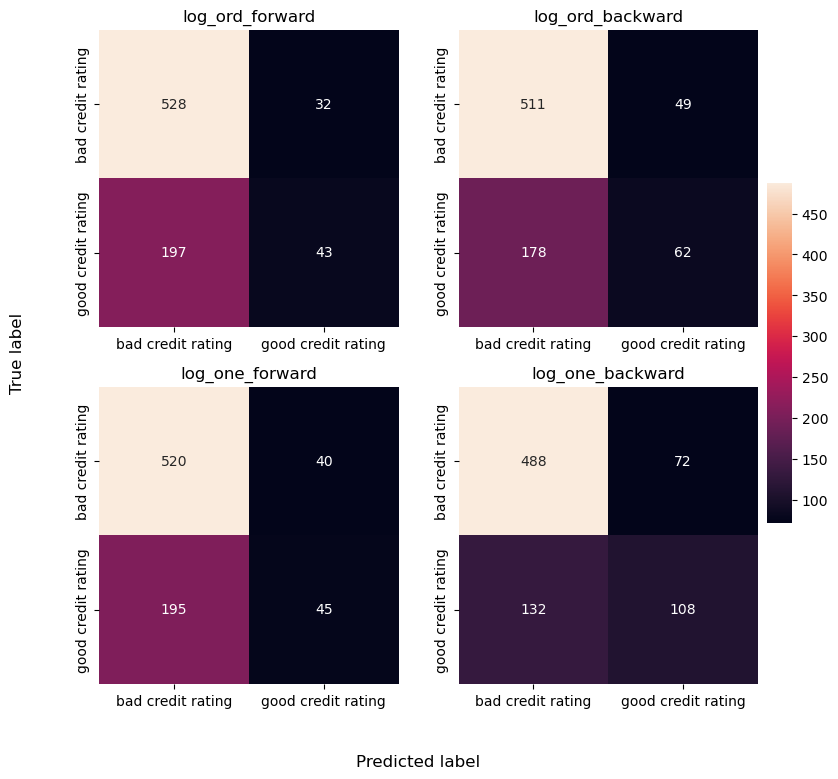

In [13]:
def plot_confusion_matrix(plot1, plot2, plot3, plot4, df_models_coefi):
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (8.5,8.5))
    cbar_ax = fig.add_axes([.91,.3,.03,.4])
    sns.heatmap(plot1, annot = True, fmt = '.3g', ax = ax1, cbar_ax = cbar_ax)
    sns.heatmap(plot2, annot = True, fmt = '.3g', ax = ax2, cbar_ax = cbar_ax)
    sns.heatmap(plot3, annot = True, fmt = '.3g', ax = ax3, cbar_ax = cbar_ax)
    sns.heatmap(plot4, annot = True, fmt = '.3g', ax = ax4, cbar_ax = cbar_ax)
    ax1.title.set_text(df_models_coefi.index[0])
    ax2.title.set_text(df_models_coefi.index[1])
    ax3.title.set_text(df_models_coefi.index[2])
    ax4.title.set_text(df_models_coefi.index[3])
    ax1.set_xticks([.5, 1.5], ['bad credit rating', 'good credit rating'])
    ax2.set_xticks([.5, 1.5], ['bad credit rating', 'good credit rating'])
    ax3.set_xticks([.5, 1.5], ['bad credit rating', 'good credit rating'])
    ax4.set_xticks([.5, 1.5], ['bad credit rating', 'good credit rating'])
    ax1.set_yticks([.5, 1.5], ['bad credit rating', 'good credit rating'])
    ax2.set_yticks([.5, 1.5], ['bad credit rating', 'good credit rating'])
    ax3.set_yticks([.5, 1.5], ['bad credit rating', 'good credit rating'])
    ax4.set_yticks([.5, 1.5], ['bad credit rating', 'good credit rating'])
    fig.supxlabel('Predicted label')
    fig.supylabel('True label')
    plt.show()

print('Training Set')
plot_confusion_matrix(plot_conf1, plot_conf2, plot_conf3, plot_conf4, df_models_coef)

Test Set


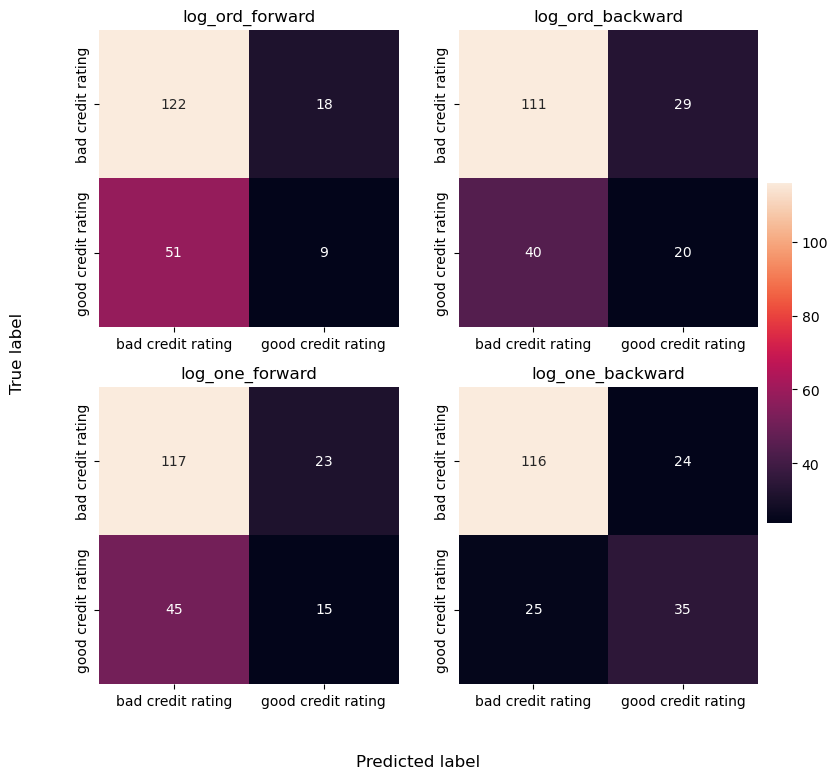

In [14]:
print('Test Set')
plot_confusion_matrix(plot_conf5, plot_conf6, plot_conf7, plot_conf8, df_models_coef)

In the previous plots we see the different models and the absolute values in which the observations were predicted. As we don't want bad credit ratings to be predicted as good, we see that all models predict 18 to 29 observations in the test set as good credit rating. Around 15 % of the cases are therefore labeled good but have a bad credit rating.

**[Back to VI. Fine Tuneing](#finetuneingmodels)**<br>

### **3. RandomForest** <a id='rffine'></a> <br>

Search via Grid Search best parameters

In [15]:
# Random Forest
#pipe_rf = Pipeline([('rf', RandomForestClassifier())])

rf_param_space = {
    'randomforestclassifier__n_estimators': range(100,501,100), #[100, 200, 300, 400, 500],
    'randomforestclassifier__max_depth': range(2,5),      # [None, 5, 10, 20]
    'randomforestclassifier__min_samples_split': range(5,10),  # [2, 5, 10]
    #'randomforestclassifier__min_samples_leaf': range(1,10),   # [1, 2, 4],
    #'randomforestclassifier__max_features': range(3, 15),    # ['auto', 'sqrt'] 
    #'randomforestclassifier__max_leaf_nodes': range(3, 15)  #[None, 5, 10, 20]
}

rf_grid_search_ord = GridSearchCV(pipe_rf, rf_param_space, cv=kfold, scoring=['accuracy', 'roc_auc', 'f1', 'precision', 'recall'], refit='roc_auc', n_jobs=-1)
rf_grid_search_one = GridSearchCV(pipe_rf_one, rf_param_space, cv=kfold, scoring=['accuracy', 'roc_auc', 'f1', 'precision', 'recall'], refit='roc_auc', n_jobs=-1)
#rf_random_search = RandomizedSearchCV(pipe_rf, rf_param_space, cv=kfold, n_iter=300,  scoring=['accuracy', 'roc_auc', 'f1', 'precision', 'recall', 'r2'], refit='roc_auc', n_jobs=-1,  random_state=0)
                                                      
rf_grid_search_ord.fit(X = train_set.iloc[:, :-1], y = preprocess_ordinal_target.fit_transform(train_set.iloc[:, [-1]]).ravel())
rf_grid_search_one.fit(X = train_set.iloc[:, :-1], y = preprocess_ordinal_target.fit_transform(train_set.iloc[:, [-1]]).ravel())

rf_cv_results_ord = pd.DataFrame(rf_grid_search_ord.cv_results_)
rf_cv_results_one = pd.DataFrame(rf_grid_search_one.cv_results_)

Overview of best parameters depending on the metrics for ordinal encoded data:

In [16]:
def rf_highest_score(grid_search):
    '''
    This function computes the scores of the Grid Search CV

    Parameters:
    grid_search : data object with grid search

    Return:
    DataFrame with scores
    '''
    # filter out the relevant columns
    rf_filtered_results = pd.DataFrame.from_dict(grid_search)

    # filter out the rows with the best metrics
    highest_accuracy = rf_filtered_results.loc[rf_filtered_results['mean_test_accuracy'].idxmax(), :]
    highest_roc_auc = rf_filtered_results.loc[rf_filtered_results['mean_test_roc_auc'].idxmax(), :]
    highest_f1 = rf_filtered_results.loc[rf_filtered_results['mean_test_f1'].idxmax(), :]
    highest_precision = rf_filtered_results.loc[rf_filtered_results['mean_test_precision'].idxmax(), :]
    highest_recall = rf_filtered_results.loc[rf_filtered_results['mean_test_recall'].idxmax(), :]

    rf_highest_scores = pd.concat([highest_accuracy, highest_roc_auc, highest_f1, highest_precision, highest_recall], axis=1).T
    rf_highest_scores['Metrics Evaluation'] = ['highest_accuracy', 'highest_roc_auc', 'highest_f1', 'highest_precision', 'highest_recall']

    # Scores on quick-and-dirty models: 0.74 0.77 0.83 0.76 0.9
    return rf_highest_scores[['Metrics Evaluation','mean_test_roc_auc', 'mean_test_recall', 'mean_test_accuracy', 'mean_test_f1', 'mean_test_precision', 'param_randomforestclassifier__max_depth', 'param_randomforestclassifier__min_samples_split', 'param_randomforestclassifier__n_estimators']]

rf_highest_score(rf_cv_results_ord)

,Metrics Evaluation,mean_test_roc_auc,mean_test_recall,mean_test_accuracy,mean_test_f1,mean_test_precision,param_randomforestclassifier__max_depth,param_randomforestclassifier__min_samples_split,param_randomforestclassifier__n_estimators
72,highest_accuracy,0.773908,0.184462,0.73625,0.29314,0.776237,4,9,300
63,highest_roc_auc,0.77961,0.168442,0.7275,0.267743,0.711648,4,7,400
60,highest_f1,0.770848,0.189051,0.7325,0.295936,0.710714,4,7,100
10,highest_precision,0.760703,0.034245,0.70875,0.065044,0.95,2,7,100
60,highest_recall,0.770848,0.189051,0.7325,0.295936,0.710714,4,7,100


Overview of best parameters depending on the metrics for one-hot encoded data:

In [17]:
rf_highest_score(rf_cv_results_one)

,Metrics Evaluation,mean_test_roc_auc,mean_test_recall,mean_test_accuracy,mean_test_f1,mean_test_precision,param_randomforestclassifier__max_depth,param_randomforestclassifier__min_samples_split,param_randomforestclassifier__n_estimators
74,highest_accuracy,0.771046,0.113341,0.72375,0.195622,0.795635,4,9,500
71,highest_roc_auc,0.776412,0.096319,0.7175,0.169067,0.735714,4,9,200
56,highest_f1,0.767178,0.117218,0.7225,0.201199,0.771429,4,6,200
45,highest_precision,0.769512,0.042712,0.71,0.07982,0.893333,3,9,100
56,highest_recall,0.767178,0.117218,0.7225,0.201199,0.771429,4,6,200


This are the best parameters in terms of roc_auc:

In [18]:
print('rf_ordinal:', rf_grid_search_ord.best_params_)
print('rf_onehot:', rf_grid_search_one.best_params_)

rf_ordinal: {'randomforestclassifier__max_depth': 4, 'randomforestclassifier__min_samples_split': 7, 'randomforestclassifier__n_estimators': 400}
rf_onehot: {'randomforestclassifier__max_depth': 4, 'randomforestclassifier__min_samples_split': 9, 'randomforestclassifier__n_estimators': 200}


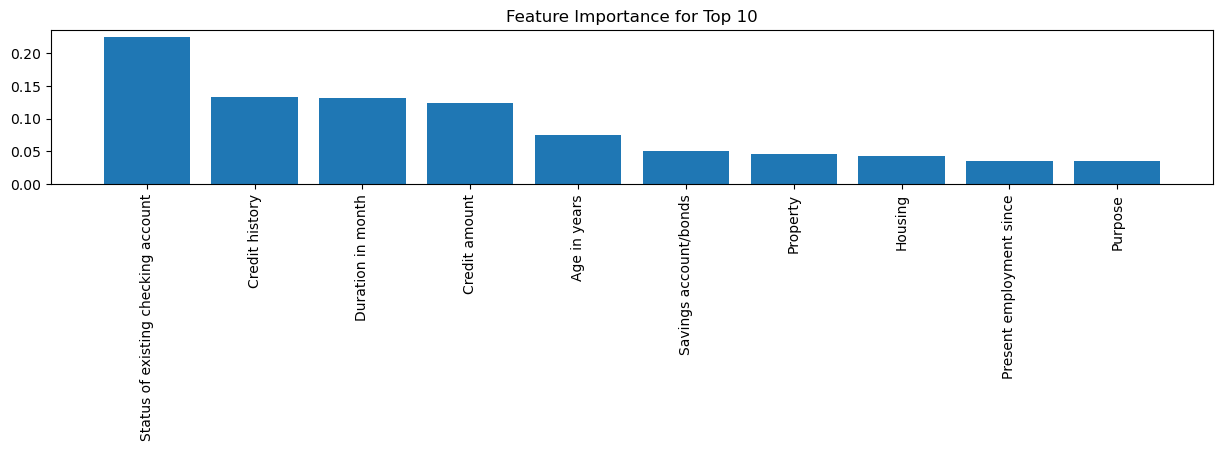

In [19]:
def feature_importance_grid_search(grid_search, preprocess):
    '''
    This function computes the scores of the Grid Search CV

    Parameters:
    grid_search : data object with grid search
    preprocess : which strategy for preprocessing

    Return:
    Plot with feature importance
    '''    
    best_estimator = grid_search.best_estimator_
    feature_importances = best_estimator['randomforestclassifier'].feature_importances_

    # Get the names of the features
    feature_names = best_estimator.get_feature_names_out

    # Sort the feature importances in descending order
    indices = np.argsort(feature_importances)[::-1]

    plt.figure(figsize=(15, 2))
    plt.bar(range(len(feature_importances[indices][:10])), feature_importances[indices][:10])
    plt.xticks(range(10), preprocess.fit_transform(train_set.iloc[:, :-1]).columns[indices][:10], rotation= 90)
    plt.title("Feature Importance for Top 10")
    plt.show()

feature_importance_grid_search(rf_grid_search_ord, preprocess_ordinal)


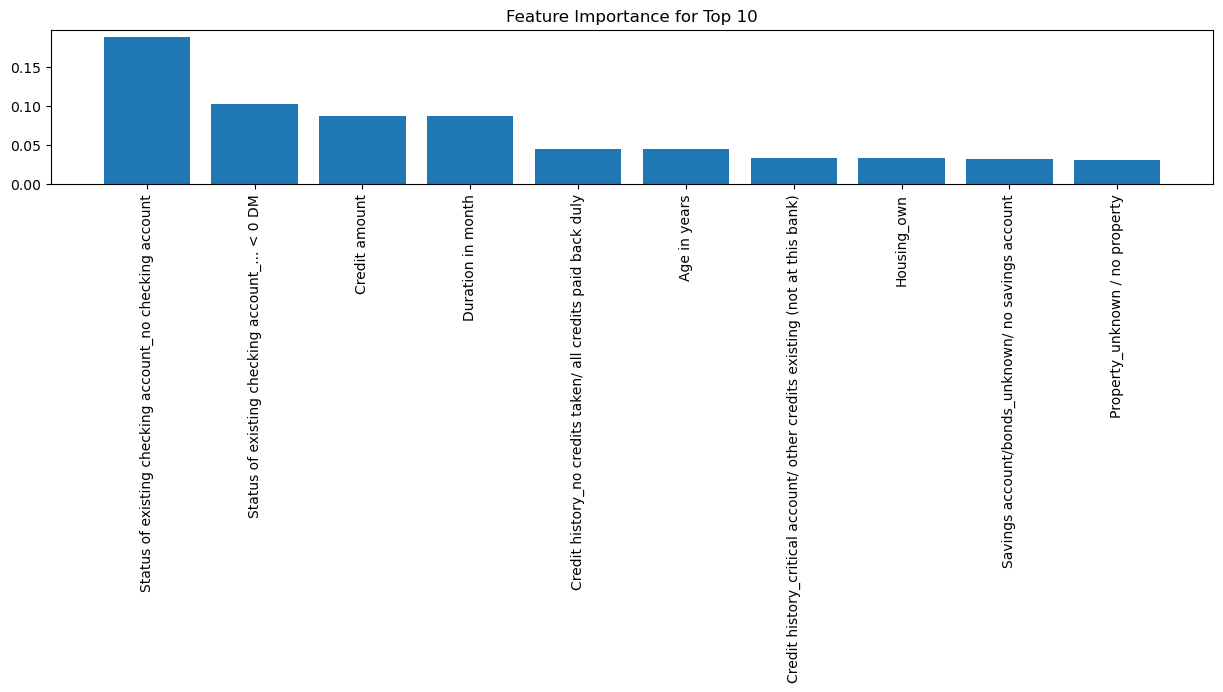

In [20]:
feature_importance_grid_search(rf_grid_search_one, preprocess_onehot)

In [21]:
rf_ord_mod_1 = pred_confusion_matrix(train_set, rf_grid_search_ord, preprocess_ordinal_target)
rf_ord_mod_2 = pred_confusion_matrix(train_set, rf_grid_search_one, preprocess_onehot_target)
rf_ord_mod_3 = pred_confusion_matrix(test_set, rf_grid_search_ord, preprocess_ordinal_target)
rf_ord_mod_4 = pred_confusion_matrix(test_set, rf_grid_search_one, preprocess_onehot_target)

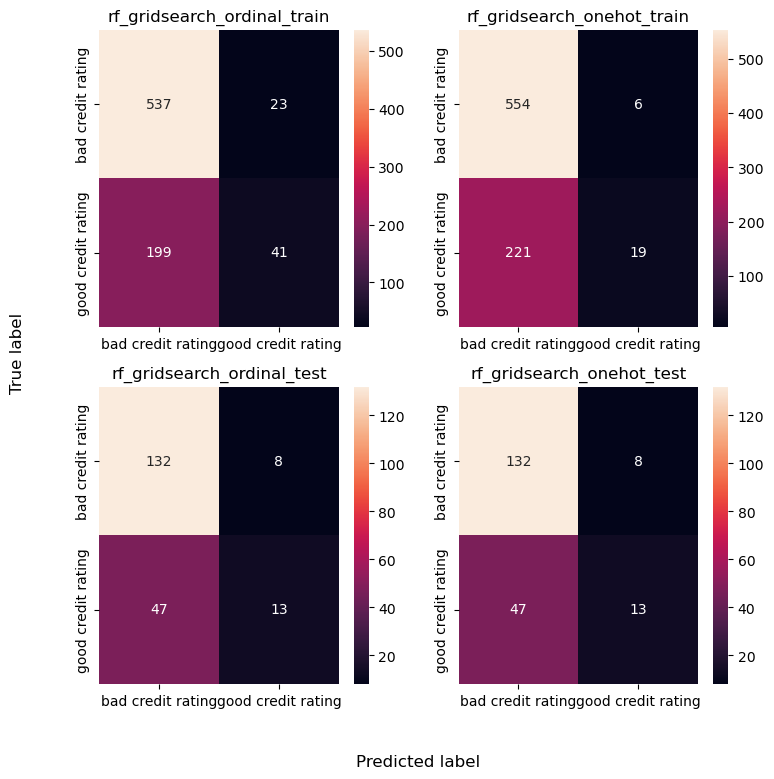

In [22]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (8.5,8.5))
sns.heatmap(rf_ord_mod_1, annot = True, fmt = '.3g', ax = ax1)
sns.heatmap(rf_ord_mod_2, annot = True, fmt = '.3g', ax = ax2)
sns.heatmap(rf_ord_mod_3, annot = True, fmt = '.3g', ax = ax3)
sns.heatmap(rf_ord_mod_3, annot = True, fmt = '.3g', ax = ax4)
ax1.title.set_text('rf_gridsearch_ordinal_train')
ax2.title.set_text('rf_gridsearch_onehot_train')
ax3.title.set_text('rf_gridsearch_ordinal_test')
ax4.title.set_text('rf_gridsearch_onehot_test')
ax1.set_xticks([.5, 1.5], ['bad credit rating', 'good credit rating'])
ax2.set_xticks([.5, 1.5], ['bad credit rating', 'good credit rating'])
ax3.set_xticks([.5, 1.5], ['bad credit rating', 'good credit rating'])
ax4.set_xticks([.5, 1.5], ['bad credit rating', 'good credit rating'])
ax1.set_yticks([.5, 1.5], ['bad credit rating', 'good credit rating'])
ax2.set_yticks([.5, 1.5], ['bad credit rating', 'good credit rating'])
ax3.set_yticks([.5, 1.5], ['bad credit rating', 'good credit rating'])
ax4.set_yticks([.5, 1.5], ['bad credit rating', 'good credit rating'])
fig.supxlabel('Predicted label')
fig.supylabel('True label')
plt.show()

Compared to the linear regression model we have two times less errors in classifying the false positives. Around 8 % are missclassified.

**[Back to VI. Fine Tuneing](#finetuneingmodels)**<br>